In [ ]:
# default_exp inference

In [ ]:
#export
import tensorflow as tf
from tensorflow.keras.models import load_model
from pathlib import Path
from PIL import Image
import os
import cv2
import numpy as np
from tqdm.notebook import tqdm

from two_stage_detector.bbox import *
from fastcore.foundation import *
from matplotlib import pyplot as plt

from fastcore.test import *

In [ ]:
from IPython.display import clear_output

In [ ]:
%config Completer.use_jedi = False

In [ ]:
#export
def load_image(img_path):
    img = tf.io.read_file(str(img_path))
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def get_n_best_bbs(bbs, scrs, n):
    x = list(zip(bbs,scrs))
    x = sorted(x, key=lambda x: x[1], reverse=True)[:n]
    bbs, scrs = tuple(zip(*x))
    return bbs, scrs

def get_bbs(img, model, threshold=0.5, n_best=None, in_absolute_coords=False):
    h, w, _ = img.shape
    img = cv2.resize(img, (400,400), cv2.INTER_AREA)
    out = model(img[None])
    scrs, bbs = out['detection_scores'].numpy(), out['detection_boxes'].numpy()
    
    bbs, scrs = bbs[0], scrs[0]
    bbs = L(BBox(bb, bb_format='array_coords') for bb in bbs)
    if in_absolute_coords: bbs = L(bb.to_absolute(w, h) for bb in bbs)
    
    if n_best: return get_n_best_bbs(bbs, scrs, n_best)
    else:      return bbs[scrs > threshold], scrs[scrs > threshold]
    

In [ ]:
bbs, scrs = [[1], [3], [2], [5]], [1, 3, 2, 5]
test_eq(get_n_best_bbs(bbs, scrs, 2), ([[5], [3]], [5, 3]))

In [ ]:
#export
def plot(imgs):
    if isinstance(imgs, np.ndarray):
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(imgs)
    else:
        n_imgs = len(imgs)
        fig, axs = plt.subplots(ncols=n_imgs, figsize=(12, 12))
        for ax, img in zip(axs, imgs): ax.imshow(img)

In [ ]:
path_det1 = '/home/addfor/projects/smart_tray/20_5006v02-intp-detection-foodv01/det1_model/saved_model'
path_det2 = '/home/addfor/projects/smart_tray/20_5006v02-intp-detection-foodv01/det2_model/saved_model'
if not det1: det1 = tf.saved_model.load(path_det1)
if not det2: det2 = tf.saved_model.load(path_det2)

NameError: name 'det1' is not defined

In [ ]:
path = Path("/mnt/data/smarttray/dataset_05jul2021_av3b/Test_Empoli_01_06_2021/train/images")
img_paths = [path/img_path for img_path in os.listdir(path)]
img = load_image(img_paths[5]).numpy()
bbs, scrs = get_bbs(img, det1, in_absolute_coords=True)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

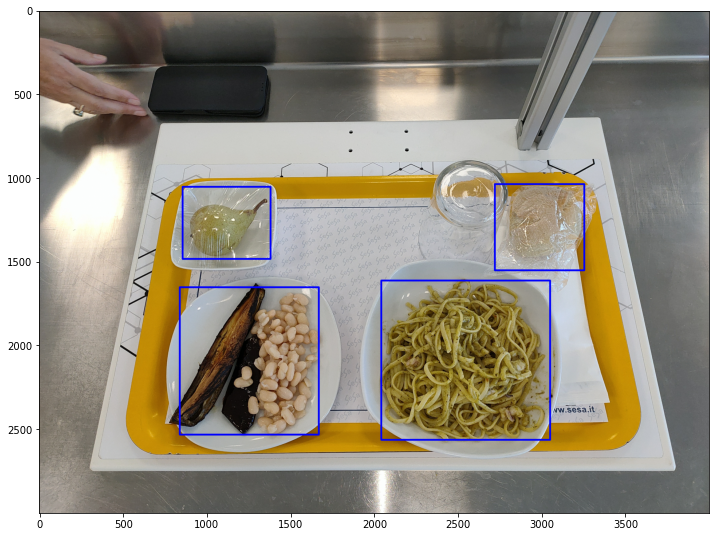

In [ ]:
draw_bbs(img, bbs)
plot(img)

In [ ]:
#export 
def get_bb_crop(img, bb):
    height, width, _ = img.shape
    bb.to_absolute(width, height)
    x1, y1, x2, y2 = bb
    return img[y1:y2, x1:x2]

def get_bb_crops(img, bbs): return [get_bb_crop(img, bb) for bb in bbs]

def get_foods_and_recipes(img, det1, det2, multi_piatto_dim=700):
    bbs, scrs = get_bbs(img, det1)
    foods = get_bb_crops(img, bbs)
    foods_rcps = []
    for food in foods:
        h, w, _ = food.shape
        if h > multi_piatto_dim and w > multi_piatto_dim: 
            rcp_bbs, scrs = get_bbs(food, det2)
            rcps = get_bb_crops(food, rcp_bbs)
            foods_rcps.append((food, rcps))
        else:
            foods_rcps.append((food,))           
    return foods_rcps

In [ ]:
path = Path("/mnt/data/smarttray/dataset_05jul2021_av3b/Test_Empoli_01_06_2021/train/images")
img_paths = [path/img_path for img_path in os.listdir(path)]

In [ ]:
for img_path in img_paths:
    img = load_image(img_path).numpy()
    cv2.resize(img, (400,400), cv2.INTER_AREA)
    results = get_foods_and_recipes(img, det1, det2)
    for result in results:
        if len(result) > 1:
            plot([result[0], *result[1]])
            plt.show()
    x = input("write 'c' to stop")
    clear_output()
    if x=='c': break    

In [ ]:
for img_path in img_paths:
    img = load_image(img_path).numpy()
    foods = get_bb_crops(img, get_bbs(img, det1, threshold=0.5)[0])
    for food in foods:
        h, w, _ = food.shape
        if h > 700 and w > 700: 
            draw_bbs(food, get_bbs(food, det2, threshold=0.6)[0])
            plot(food); plt.show()
            x = input("write 'c' to stop")
            clear_output()
            if x=='c': break    
    if x=='c': break    